In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os
import math
import random
import numpy as np    
import seaborn as sns

# Configure Visualization Defaults
%matplotlib inline
plt.rcParams['figure.figsize'] = 12,8

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Exploratory Data Analysis

In [2]:
df = pd.read_csv("../data/training_set_VU_DM.csv", nrows=5000)

In [3]:
df.head()

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,...,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool
0,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,893,3,3.5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
1,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,10404,4,4.0,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
2,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,21315,3,4.5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
3,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,27348,2,4.0,...,NaN,NaN,NaN,NaN,-1.0,0.0,5.0,0,NaN,0
4,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,29604,4,3.5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0


### In this dataset we count 129.113 unique hotels

In [4]:
# Change time information to year and month columns
df["date_time"] = pd.to_datetime(df["date_time"])
df["year"] = df["date_time"].dt.year
df["month"] = df["date_time"].dt.month

In [60]:
# Correlation heatmap of dataset
def correlation_heatmap(df):
    sns.set(font_scale=1)
    fig = plt.figure()
    _ , ax = plt.subplots(figsize =(10, 10))
#     colormap = sns.diverging_palette(220, 10, as_cmap = True)
    cmap = sns.cubehelix_palette(light=1.2, as_cmap=True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = cmap,
        square=True,
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':10 }
    )
    _.figure.tight_layout()

In [ ]:
# Groups of attributes
visitor = list(range(3,6))
prop = list(range(6,17))
prop.remove(14)
srch = list(range(17,24))
target = list(range(51,54))
target.append(14)

correlation_heatmap(df.iloc[:,prop+target])
plt.title('Correlation Matrix of proptery features',fontdict = {'fontsize' : 16})
plt.savefig("../plots/correlation.pdf")

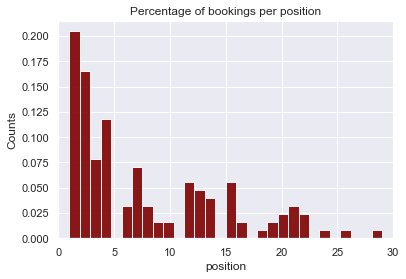

In [111]:
fig = plt.gcf()
sns.set_style("darkgrid")
plt.xlim(0, 30)
sns.distplot(df.loc[df['booking_bool'] == 1, 'position'], 
             bins=30,  
             hist_kws={ "linewidth": 1,"alpha": 0.9, "color": "maroon"},
             kde_kws={"color": "k", "lw": 0})
plt.ylabel('Counts'), plt.xlabel('position')
plt.title('Percentage of bookings per position')
plt.show()
fig.savefig("../plots/bookings_per_pos.pdf")

## Analyse comp_rate_diff --> difference in price for Expedia competitor and difference in availability

In [ ]:
import seaborn as sns
sns.set()

compare_cols = ["comp1_rate", "comp2_rate", "comp3_rate", "comp4_rate", "comp5_rate",
                "comp6_rate", "comp7_rate", "comp8_rate"]

total_diff = []
[total_diff.append(np.mean(df[col])) for col in compare_cols]

def showcompareplot(compare_cols, total_diff, title):
    fig, ax = plt.subplots(figsize=(10,5))
    ax.set(ylabel='Mean of the whole column', title=title)
    sns.barplot(compare_cols, total_diff)

showcompareplot(compare_cols, total_diff, title="Price in comparison to competitor 1 for all data; \
            positive = lower price!")

### On average, Expedia has a lower price than competitor 1 for the hotel. For competitor 4, Expedia has a higher price (on average!). However, when we look at availability we see that for competitor 4, the availability is slightly higher than other competitors. On the other hand, this is only about 10%. 

In [ ]:
compare_cols_inv = ["comp1_inv", "comp2_inv", "comp3_inv", "comp4_inv", "comp5_inv",
                "comp6_inv", "comp7_inv", "comp8_inv"]

total_diff = []
[total_diff.append(np.mean(df[col])) for col in compare_cols_inv]
    
showcompareplot(compare_cols_inv, total_diff, "Availability rates for all dataset")

In [ ]:
# Add comp_inv and comp_rate together 
for i in range (len(compare_cols)):
    df["combine_inv_rate" + str(i + 1)] = df[compare_cols_inv[i]] + df[compare_cols[i]]

compare_cols_total = ["combine_inv_rate1", "combine_inv_rate2", "combine_inv_rate3", "combine_inv_rate4",
                      "combine_inv_rate5", "combine_inv_rate6", "combine_inv_rate7", "combine_inv_rate8"]
total_diff = []
[total_diff.append(np.mean(df[col])) for col in compare_cols_total]
    
showcompareplot(compare_cols_total, total_diff, "Availability rates for all dataset")

In [ ]:
# Make a new column for when there exists a competitor
competitor_bools = []

for index, row in df.iterrows():
    comp_bool = 0
    
    # compare_cols_total exists of a column of data from comp_rate and comp_inv,
    # so, a combination of competitor price and room-availability. 
    for competitor in compare_cols_total:
        if row[competitor] == 1:
            comp_bool = 1
    competitor_bools.append(comp_bool)
df["competitor_bool"] = competitor_bools

In [ ]:
plt.figure(figsize=(4, 4))
sns.countplot(x="competitor_bool", data=df).set_title("Existence of a competitor; 0 = False, 1 = True")

In [ ]:
# Drop all other comp_rate and comp_inv columns:
df = df.drop(compare_cols_inv, axis=1)
df = df.drop(compare_cols, axis=1)
df = df.drop(compare_cols_total, axis=1)

### Most people search for a one night stay and with two people (adults) and no children. 

In [ ]:
from matplotlib.ticker import ScalarFormatter

plt.figure(figsize=(7, 4))
countplot = sns.countplot(x="srch_length_of_stay", data=df)
plt.xlabel('Length of stay')
plt.ylabel('Frequency')
plt.title("Number of search per length of stay")
countplot.set_xlim(-1,14)
# plt.ticker.LogFormatterSciNotation

plt.show()
countplot.figure.savefig("plots/srch_length_of_stay.pdf", bbox_inches='tight')


plt.figure(figsize=(11, 4))
sns.countplot(x="srch_adults_count", data=df)

plt.figure(figsize=(11, 4))
sns.countplot(x="srch_children_count", data=df)

### Most people visit the website from the US (id = 219).

In [ ]:
# Get five most frequent countries 
print(df['visitor_location_country_id'].value_counts()[:5].index.tolist())
sns.distplot(df['visitor_location_country_id'], label="User country")
plt.legend()

## Clean price data

#### There are a lot of prices between 7 and 240, then outlying category between 240 and 554655:
#### Categories (7, interval[float64]): [(6.0889999999999995, 69.0] < (69.0, 90.0] < (90.0, 110.0] < (110.0, 136.0] < (136.0, 170.077] < (170.077, 239.0] < (239.0, 554655.0]]

## Note that different countries have different conventions regarding displaying taxes and fees and the value may be per night or for the whole stay

## For this reason, the choice was made to only select the US 

In [ ]:
df_us = df.loc[df['visitor_location_country_id'] == 219].copy()

### There are a lot less clicks for the hotels with higher price (as expected)

In [ ]:
# Correct for number of nights
df_us["price_correction"] = df_us["price_usd"] / df_us["srch_length_of_stay"]

df_us.groupby('click_bool')['price_usd'].describe()

In [ ]:
df_us['PriceBand'] = pd.qcut(df_us["price_correction"], 7)
df_us['PriceBand'].head(10)

In [ ]:
import seaborn as sns
import matplotlib.pylab as plt

plt.clf()
plt.xlim(0, 1000)
sns.distplot(df_us['price_usd'], bins=10000, label="User country")

In [ ]:
# Categorize into labels
df_us['PriceBand'] = pd.qcut(df_us["price_correction"], 7, labels=[0,1,2,3,4,5,6])

### Add column that tells us whether someone has visited a hotel before

In [ ]:
hist_starrating = df.visitor_hist_starrating.isna()
hist_adr = df.visitor_hist_adr_usd.isna()

# Dit kan waarschijnlijk veel mooier en sneller maar het werkt...
total_visited = []
for index, row in df.iterrows():
    if hist_starrating[index] or hist_adr[index]:
        visited = 0
    else:
        visited = 1
    total_visited.append(visited)
    
df["total_visited"] = total_visited

# lookup = df.loc[:, 'visitor_hist_starrating':'visitor_hist_adr_usd'].notnull().idxmax(1)
# df.assign(visited_before=df.lookup(lookup.index, lookup.values))

In [ ]:
plt.figure(figsize=(4, 4))
sns.countplot(x="total_visited", data=df).set_title("Visited hotel before or not; 0 = False, 1 = True")

In [ ]:
sns.distplot(df['prop_location_score1'], label="prop_location_score")